--- auto compile ---
--- auto compile complete ---
initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=1000, dx=0.0010, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
--- compile cuSOLVER ---


Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
/home/arlm/workspace/venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module gtsv_batch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF gtsv_binding.o.d -DTORCH_EXTENSION_NAME=gtsv_batch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda-12.6/include -isystem /usr/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -O3 -c /home/arlm/workspace/kineticEQ/src/kineticEQ/backends/gtsv/gtsv_binding.cpp -o gtsv_binding.o 
[2/3] /usr/local/cuda-12.6/bin/nvcc --generate-dependencies-with-compile --dependency-output gtsv_batch.cuda.o.d -DTORCH_EXTENSION_NAME=gtsv_batch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages

Loading extension module gtsv_batch...
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module implicit_fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/local/cuda-12.6/bin/nvcc --generate-dependencies-with-compile --dependency-output implicit_kernels.cuda.o.d -DTORCH_EXTENSION_NAME=implicit_fused -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda-12.6/include -isystem /usr/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_80,code=sm_80 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -O3 -std=c++17 -c /home/arlm/workspace/kineticEQ/src/kineticEQ/backends/implicit_fused/implicit_kernels.cu -o implicit_kernels.cuda.o 
[2/3] c++ -MMD -MF i

Loading extension module implicit_fused...
NoneType: None
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module lo_blocktridiag...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF block_tridiag_binding.o.d -DTORCH_EXTENSION_NAME=lo_blocktridiag -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda-12.6/include -isystem /usr/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -O3 -c /home/arlm/workspace/kineticEQ/src/kineticEQ/backends/lo_blocktridiag/block_tridiag_binding.cpp -o block_tridiag_binding.o 
[2/3] /usr/local/cuda-12.6/bin/nvcc --generate-dependencies-with-compile --dependency-output block_tridiag_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=lo_blocktridiag -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isys

Loading extension module lo_blocktridiag...
NoneType: None
Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.91it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 304.71it/s]


--- tau_tilde: 0.0005 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:19<00:00,  5.26it/s]


--- PICARD ---


Progress: 100%|██████████████████████████████████████████████████████| 101/101 [00:00<00:00, 110.45it/s]


--- tau_tilde: 5e-05 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:22<00:00,  4.42it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:04<00:00, 21.00it/s]


--- tau_tilde: 5e-06 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:24<00:00,  4.21it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:32<00:00,  3.11it/s]


--- tau_tilde: 5e-07 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.93it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [03:18<00:00,  1.97s/it]


--- tau_tilde: 5e-08 ---
--- HOLO ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.89it/s]


--- PICARD ---


Progress: 100%|███████████████████████████████████████████████████████| 101/101 [04:29<00:00,  2.67s/it]


--- Convergence Test Completed ---
ベンチマーク結果を保存: Conv_bench.pkl  (0.25 MB)
収束性テストの図を保存: Conv_bench.png


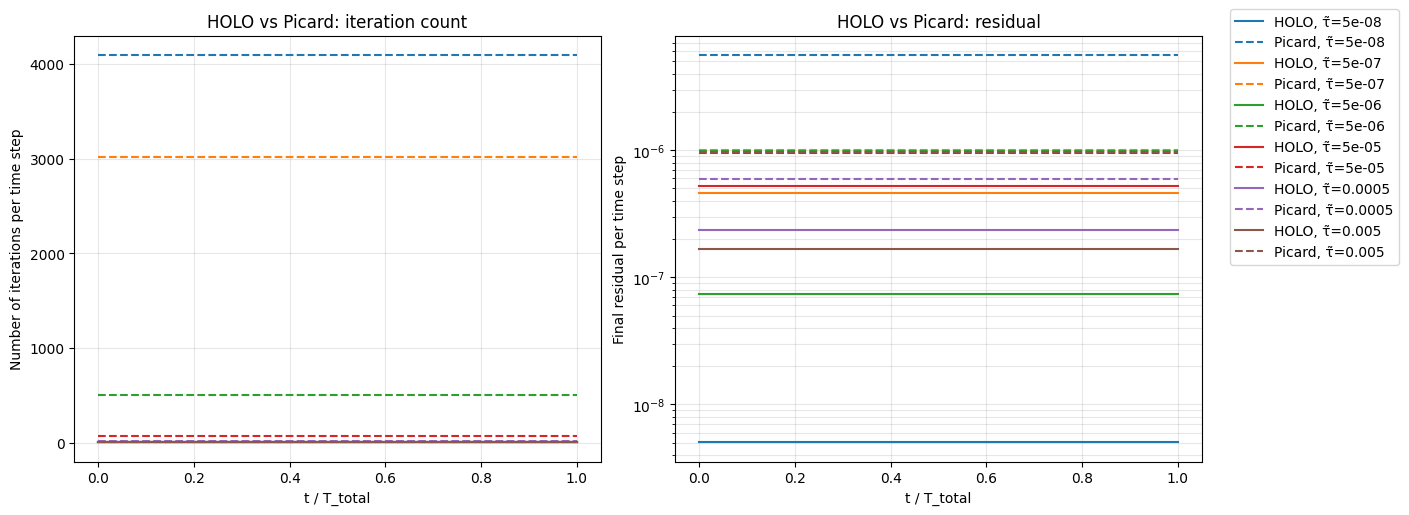

In [ ]:
%run kineticEQ/tests/benchmarks/convergence_test.py --nv 200 --nx 500 --picard_tol 1e-4 --ho_tol 1e-4 --lo_tol 1e-4